In [2]:
# path setup
import sys
import os
module_path = os.path.abspath(os.path.join('../../'))
sys.path.insert(1, module_path + "/utils")

## db setup
# pip install sqlalchemy
from sqlalchemy import create_engine
from getpass import getpass 

# pandas setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from modeling import lag_columns, extract_date_features
from data_from_db import get_table_from_shelter

In [3]:
df = get_table_from_shelter('shelter_climate')

#### focus on Toronto

In [4]:
df = df[df['location_city'] == 'Toronto']
df['capacity_units'] = df['taken_units'] + df['free_units']
df

,date,location_city,sector,overnight_service_type,capacity_type,taken_units,free_units,capacity_rate,availability,min_temperature,total_precipitation,mean_temperature,max_temperature,snow_on_ground,capacity_units
0,01.01.24,Toronto,Families,Motel/Hotel Shelter,Room,149.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,149.0
1,01.01.24,Toronto,Mixed Adult,Motel/Hotel Shelter,Room,57.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,57.0
2,01.01.24,Toronto,Mixed Adult,Shelter,Bed,8.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,8.0
3,01.01.24,Toronto,Families,Motel/Hotel Shelter,Room,67.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,67.0
4,01.01.24,Toronto,Families,Motel/Hotel Shelter,Room,161.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128342,31.12.23,Toronto,Youth,Shelter,Bed,40.0,0.0,1.000000,0.000000,-1.0,2.3,0.3,1.6,0.0,40.0
128343,31.12.23,Toronto,Women,Shelter,Bed,30.0,0.0,1.000000,0.000000,-1.0,2.3,0.3,1.6,0.0,30.0
128344,31.12.23,Toronto,Youth,Shelter,Bed,31.0,0.0,1.000000,0.000000,-1.0,2.3,0.3,1.6,0.0,31.0
128345,31.12.23,Toronto,Women,Shelter,Bed,27.0,1.0,0.964286,0.035714,-1.0,2.3,0.3,1.6,0.0,28.0


#### try on time sereis model

In [5]:
df.dtypes
time_series_data = df[['date', 'capacity_units']]
display(time_series_data.dtypes)
time_series_data

date               object
capacity_units    float64
dtype: object

,date,capacity_units
0,01.01.24,149.0
1,01.01.24,57.0
2,01.01.24,8.0
3,01.01.24,67.0
4,01.01.24,161.0
...,...,...
128342,31.12.23,40.0
128343,31.12.23,30.0
128344,31.12.23,31.0
128345,31.12.23,28.0


In [6]:
# Calculate monthly averages
grouped_data = time_series_data.groupby('date')['capacity_units'].sum().reset_index()
time_series_data

,date,capacity_units
0,01.01.24,149.0
1,01.01.24,57.0
2,01.01.24,8.0
3,01.01.24,67.0
4,01.01.24,161.0
...,...,...
128342,31.12.23,40.0
128343,31.12.23,30.0
128344,31.12.23,31.0
128345,31.12.23,28.0


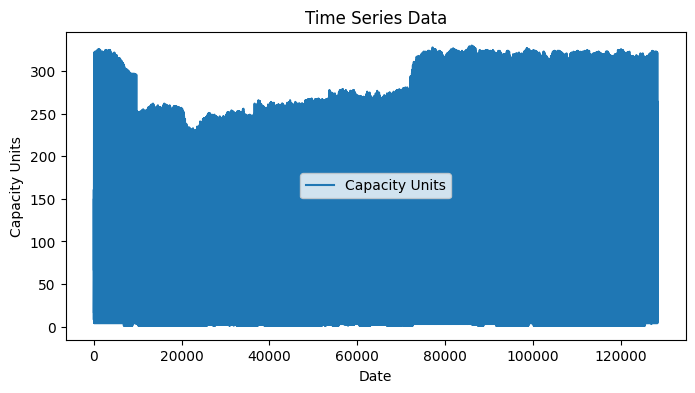

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next v

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Plot the Time Series Data
plt.figure(figsize=(8, 4)) 
plt.plot(time_series_data.index, time_series_data['capacity_units'], label='Capacity Units')
plt.xlabel('Date')
plt.ylabel('Capacity Units')
plt.title('Time Series Data')
plt.legend()
plt.show()


# Split Data into Training and Test Sets
n_test = 12  # Number of observations for the test set
train = time_series_data.iloc[:-n_test]
test = time_series_data.iloc[-n_test:]

# Fit ARIMA Model
p, d, q = 1, 1, 1  # ARIMA parameters (adjust as needed)
model = ARIMA(train['capacity_units'], order=(p, d, q))
arima_result = model.fit()

# Make Forecasts
forecasts = arima_result.forecast(steps=n_test)

# Evaluate the Model
# Compute metrics (e.g., MSE, MAE)
# For example, if you have the actual values in 'test' DataFrame
mse = ((forecasts - test['capacity_units']) ** 2).mean()
mae = (forecasts - test['capacity_units']).abs().mean()



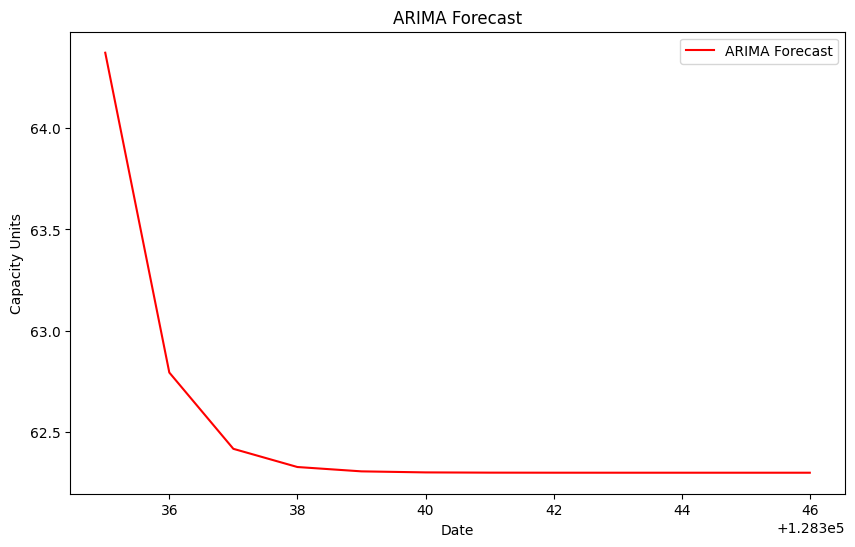

In [14]:
# Visualize Forecasts
plt.figure(figsize=(10, 6))
#plt.plot(train.index, train['capacity_units'], label='Training Data')
plt.plot(test.index, forecasts, label='ARIMA Forecast', linestyle='-', marker='', color='red')  # Adjust linestyle and marker
plt.xlabel('Date')
plt.ylabel('Capacity Units')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

In [28]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test['capacity_units'], forecasts)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(forecasts - test['capacity_units']))

# Calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test['capacity_units'], forecasts)

# Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

smape = symmetric_mean_absolute_percentage_error(test['capacity_units'], forecasts)

# Calculate Mean Absolute Scaled Error (MASE)
def mean_absolute_scaled_error(y_true, y_pred, naive_forecast):
    mae = np.mean(np.abs(y_true - y_pred))
    naive_mae = np.mean(np.abs(y_true - naive_forecast))
    return mae / naive_mae

# Compute naive forecast (e.g., historical average)
naive_forecast = train['capacity_units'].mean()

mase = mean_absolute_scaled_error(test['capacity_units'], forecasts, naive_forecast)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Symmetric Mean Absolute Percentage Error (SMAPE):", smape)
print("Mean Absolute Scaled Error (MASE):", mase)


Mean Squared Error (MSE): 1435.7302495348376
Root Mean Squared Error (RMSE): 37.891031254570485
Mean Absolute Error (MAE): nan
Mean Absolute Percentage Error (MAPE): nan
Symmetric Mean Absolute Percentage Error (SMAPE): 0.0
Mean Absolute Scaled Error (MASE): nan
